In [1]:
import time
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from numba import njit, prange
from typing import List, Tuple
import glob
import os
import math

In [2]:
# ---------------- Gamma Correction ----------------
def inv_gamma(u: np.ndarray) -> np.ndarray:
    """Convert sRGB values [0,1] to linear RGB."""
    mask = (u <= 0.04045)
    return np.where(mask, u / 12.92, ((u + 0.055) / 1.055) ** 2.4)

def gamma_corr(u: np.ndarray) -> np.ndarray:
    """Convert linear RGB [0,1] back to sRGB."""
    mask = (u <= 0.0031308)
    return np.where(mask, 12.92 * u, 1.055 * (u ** (1 / 2.4)) - 0.055)

### Poisson disk sampling

In [3]:
# ---------------- Poisson Disk Sampling ----------------
def poisson_disk_sampling(image: np.ndarray,
                          num_samples=27,
                          initial_rs=0.1,
                          min_rs=0.01,
                          max_attempts=5000) -> np.ndarray:
    t0 = time.time()
    pixels = image.reshape(-1, 3).copy()
    np.random.shuffle(pixels)
    rs = initial_rs
    attempts = 0
    samples = []
    while len(samples) < num_samples and rs >= min_rs:
        for color in pixels:
            if not samples or np.min(np.linalg.norm(np.array(samples)-color, axis=1)) >= 2*rs:
                samples.append(color)
                if len(samples) >= num_samples:
                    break
            attempts += 1
            if attempts > max_attempts:
                rs *= 0.5
                attempts = 0
                break
    samples = np.array(samples, dtype=np.float32)
    print(f"[Sampler] Poisson disk sampling: {time.time()-t0:.3f}s → {len(samples)} samples")
    return samples

### Spatial Filtering O(1)

#### Box Filter O(1)

In [4]:
# ---------------- Box‐filter O(1) ---------------------------
# cv2 (C++)
def box_filter(img: np.ndarray,
               samples: np.ndarray,
               sigma_r: float = 0.1,
               spatial_radius: int = 15,
               eps: float = 1e-6):
    Jks, Wks = [], []
    ksize = (2*spatial_radius + 1, ) * 2   # (ksize, ksize)

    for k in samples.astype(np.float32):
        diff = img - k[None, None, :]
        d2   = np.sum(diff * diff, axis=2, dtype=np.float32)
        w    = np.exp(-d2 / (2 * sigma_r * sigma_r), dtype=np.float32)  # (H,W)

        num = cv2.boxFilter((img * w[..., None]).astype(np.float32),
                            ddepth=-1, ksize=ksize,
                            normalize=False,
                            borderType=cv2.BORDER_REFLECT)

        Wk  = cv2.boxFilter(w, ddepth=-1, ksize=ksize,
                            normalize=False,
                            borderType=cv2.BORDER_REFLECT) + eps

        Jks.append(num)
        Wks.append(Wk.squeeze())

    return Jks, Wks


#### Gaussian-filter O(1) IIR implement

In [5]:
import math
import numpy as np
from numba import njit, prange

# ---------- 1) Deriche coefficients ----------
@njit(cache=True, fastmath=True)
def deriche_coeffs(sigma: float):
    if sigma <= 0:
        raise ValueError("sigma must be > 0")
    alpha = 1.793 / sigma
    ema   = math.exp(-alpha)
    ema2  = math.exp(-2 * alpha)
    k     = (1 - ema) ** 2 / (1 + 2 * alpha * ema - ema2)

    a0 = k
    a1 = k * (alpha - 1) * ema
    a2 = k * (alpha + 1) * ema
    a3 = -k * ema2
    b1 = 2 * ema
    b2 = - ema2
    return a0, a1, a2, a3, b1, b2

# ---------- 2) 1D Deriche filter with mirror-init ----------
@njit(fastmath=True, cache=True)
def deriche_line(src, dst, a0, a1, a2, a3, b1, b2):
    N, C = src.shape
    for c in range(C):
        # forward pass: init from leftmost pixel (mirror)
        xm1 = src[0, c]
        ym1 = src[0, c]
        ym2 = src[0, c]
        for n in range(N):
            x = src[n, c]
            y = a0 * x + a1 * xm1 + b1 * ym1 + b2 * ym2
            dst[n, c] = y
            xm1, ym2, ym1 = x, ym1, y

        # backward pass: init from rightmost pixel (mirror)
        xp1 = src[N-1, c]
        xp2 = src[N-1, c]
        yp1 = src[N-1, c]
        yp2 = src[N-1, c]
        for n in range(N-1, -1, -1):
            x = src[n, c]
            y = a2 * xp1 + a3 * xp2 + b1 * yp1 + b2 * yp2
            dst[n, c] += y
            xp2, xp1, yp2, yp1 = xp1, x, yp1, y

# ---------- 3) Separable Deriche for 2D images ----------
@njit(parallel=True, fastmath=True, cache=True)
def gauss_iir_sep(img, sigma):
    a0, a1, a2, a3, b1, b2 = deriche_coeffs(sigma)
    H, W, C = img.shape
    tmp = np.empty_like(img)
    out = np.empty_like(img)
    # rows
    for y in prange(H):
        deriche_line(img[y], tmp[y], a0, a1, a2, a3, b1, b2)
    # cols
    for x in prange(W):
        deriche_line(tmp[:, x, :], out[:, x, :], a0, a1, a2, a3, b1, b2)
    return out

# ---------- 4) Gaussian‐IIR + mirror‐pad + crop ----------
def gaussian_iir_filter(img: np.ndarray,
                        samples: np.ndarray,
                        sigma_r: float = 0.1,
                        spatial_radius: int = 15):
    sigma_s = float(spatial_radius/3.0)
    pad     = int(3 * sigma_s)
    img_pad = np.pad(img, ((pad, pad), (pad, pad), (0, 0)), mode='reflect')

    Jks, Wks = [], []
    for k in samples.astype(np.float32):
        diff = img - k[None, None, :]
        d2   = np.sum(diff * diff, axis=2, dtype=np.float32)
        w    = np.exp(-d2 / (2 * sigma_r * sigma_r), dtype=np.float32)  # (H,W)
        w_pad = np.pad(w, ((pad, pad), (pad, pad)), mode='reflect')
        
        Jk_pad = gauss_iir_sep((img_pad * w_pad[..., None]).astype(np.float32), sigma_s)
        Wk_pad = gauss_iir_sep(w_pad[..., None].astype(np.float32), sigma_s).squeeze()

        Jk = Jk_pad[pad:-pad, pad:-pad, :]
        Wk = Wk_pad[pad:-pad, pad:-pad]

        Jks.append(Jk)
        Wks.append(Wk)

    return Jks, Wks


#### Brute-force filter O(r^2)

In [6]:
#--------------- Brute-force filter O(r^2) ------------------------

def gaussian_kernel(spatial_radius: int, sigma: float):
    ax = np.arange(-spatial_radius, spatial_radius + 1, dtype=np.float32)
    xx, yy = np.meshgrid(ax, ax)
    k = np.exp(-(xx**2 + yy**2) / (2 * sigma**2))
    return (k / k.sum()).astype(np.float32)

@njit(parallel=True, fastmath=True)
def _blur_for_loop(I: np.ndarray, kernel: np.ndarray):
    H, W = I.shape[:2]
    r = kernel.shape[0] // 2
    if I.ndim == 2:
        out = np.empty_like(I)
        for y in prange(H):
            for x in range(W):
                s = 0.0
                for ky in range(-r, r + 1):
                    yy = min(H - 1, max(0, y + ky))
                    row_k = kernel[ky + r]
                    for kx in range(-r, r + 1):
                        xx = min(W - 1, max(0, x + kx))
                        s += row_k[kx + r] * I[yy, xx]
                out[y, x] = s
    else:
        out = np.empty_like(I)
        for y in prange(H):
            for x in range(W):
                sr = sg = sb = 0.0
                for ky in range(-r, r + 1):
                    yy = min(H - 1, max(0, y + ky))
                    row_k = kernel[ky + r]
                    for kx in range(-r, r + 1):
                        xx = min(W - 1, max(0, x + kx))
                        w = row_k[kx + r]
                        sr += w * I[yy, xx, 0]
                        sg += w * I[yy, xx, 1]
                        sb += w * I[yy, xx, 2]
                out[y, x, 0] = sr
                out[y, x, 1] = sg
                out[y, x, 2] = sb
    return out

def brute_force_filter(img: np.ndarray,
                             samples: np.ndarray,
                             sigma_r: float = 0.1,
                             spatial_radius: int = 15
                             ) -> Tuple[List[np.ndarray], List[np.ndarray]]:

    img_f = img.astype(np.float32)
    sigma_s = float(spatial_radius / 3.0)
    ker = gaussian_kernel(spatial_radius, sigma_s)
    Jks, Wks = [], []

    for k in samples.astype(np.float32):
        diff = img_f - k[None, None, :]
        d2 = (diff * diff).sum(axis=2)
        wr = np.exp(-d2 / (2 * sigma_r**2)).astype(np.float32)
        Wk = _blur_for_loop(wr, ker)
        Iw = img_f * wr[:, :, None]
        Jk = _blur_for_loop(Iw, ker)
        Jks.append(Jk)
        Wks.append(Wk)

    return Jks, Wks

In [7]:
@njit(fastmath=True, inline='always')
def _sqdist(c1, c2):
    return (c1[0]-c2[0])**2 + (c1[1]-c2[1])**2 + (c1[2]-c2[2])**2

@njit(parallel=True, fastmath=True)
def interpolate_numba(img, samples, J, W, k_nn=4, eps=1e-6):
    H, Wd, _ = img.shape
    K = samples.shape[0]
    out = np.empty_like(img)

    for y in prange(H):
        for x in range(Wd):
            p0 = img[y, x]
            best_idx = np.empty(k_nn, np.int32)
            best_d   = np.full(k_nn, 1e9, np.float32)

            for k in range(K):
                d = _sqdist(samples[k], p0)
                for t in range(k_nn):
                    if d < best_d[t]:
                        for s in range(k_nn-1, t, -1):
                            best_d[s]   = best_d[s-1]
                            best_idx[s] = best_idx[s-1]
                        best_d[t]   = d
                        best_idx[t] = k
                        break

            dmin = best_d[0] if best_d[0] > eps else eps
            acc  = np.zeros(3, np.float32)
            wacc = 0.0
            for j in range(k_nn):
                k = best_idx[j]
                wcol = np.exp(-best_d[j] / (2 * dmin))
                wden = W[k, y, x] + eps
                acc += wcol * (J[k, y, x] / wden)
                wacc += wcol
            out[y, x] = acc / wacc

    return np.clip(out, 0.0, 1.0)


def interpolate(img: np.ndarray,
                samples: np.ndarray,
                Jks: list,
                Wks: list,
                k_nn: int = 4):
    J = np.stack(Jks).astype(np.float32)   # (K,H,W,3)
    W = np.stack(Wks).astype(np.float32)   # (K,H,W)
    return interpolate_numba(img.astype(np.float32),
                             samples.astype(np.float32),
                             J, W, k_nn=k_nn)

### Test

[Sampler] Poisson disk sampling: 0.397s → 27 samples


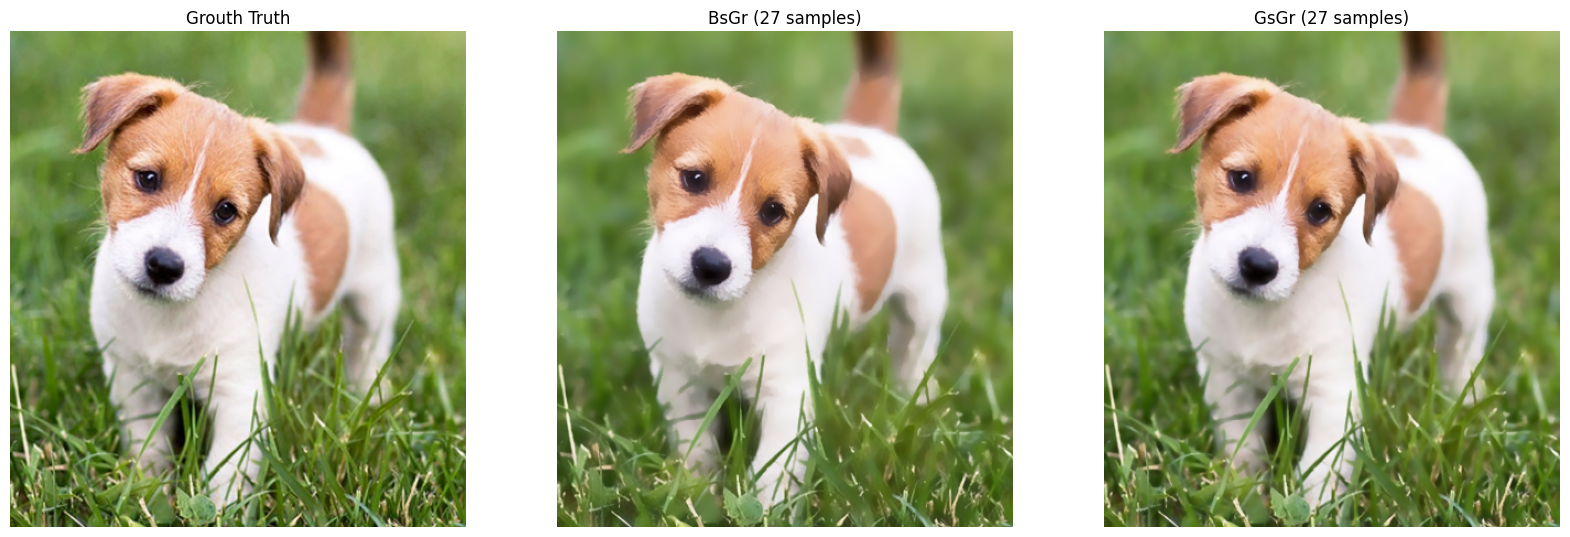

In [8]:
# ---------------- Test Pipeline ----------------
# 1. Load test image
img_bgr = cv2.imread(r'D:\Image Processing\test\dog.jpg')
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB).astype(np.float32)/255.0

# 2. Linearize and pipeline
img_lin = inv_gamma(img_rgb)
samples = poisson_disk_sampling(img_lin, num_samples=27, initial_rs=0.1)

Jks_bs, Wks_bs = box_filter(img_lin, samples, sigma_r=0.1, spatial_radius = 5)
out_lin_bs = interpolate(img_lin, samples, Jks_bs, Wks_bs)
out_srgb_bs = gamma_corr(out_lin_bs)

Jks_gs, Wks_gs = gaussian_iir_filter(img_lin, samples, sigma_r=0.1, spatial_radius = 5)
out_lin_gs = interpolate(img_lin, samples, Jks_gs, Wks_gs)
out_srgb_gs = gamma_corr(out_lin_gs)

# 3. Display results
fig, axs = plt.subplots(1,3,figsize=(20,12))
axs[0].imshow(img_rgb); axs[0].set_title('Grouth Truth'); axs[0].axis('off')
axs[1].imshow(np.clip(out_srgb_bs,0,1)); axs[1].set_title('BsGr (27 samples)'); axs[1].axis('off')
axs[2].imshow(np.clip(out_srgb_gs,0,1)); axs[2].set_title('GsGr (27 samples)'); axs[2].axis('off')
plt.show()

[Sampler] Poisson disk sampling: 0.346s → 27 samples
[Sampler] Poisson disk sampling: 0.340s → 64 samples
[Sampler] Poisson disk sampling: 0.217s → 27 samples
[Sampler] Poisson disk sampling: 0.467s → 64 samples
[Sampler] Poisson disk sampling: 0.458s → 27 samples
[Sampler] Poisson disk sampling: 0.410s → 64 samples
[Sampler] Poisson disk sampling: 0.391s → 27 samples
[Sampler] Poisson disk sampling: 0.314s → 64 samples
[Sampler] Poisson disk sampling: 0.302s → 27 samples
[Sampler] Poisson disk sampling: 0.471s → 64 samples
[Sampler] Poisson disk sampling: 0.248s → 27 samples
[Sampler] Poisson disk sampling: 0.372s → 64 samples
[Sampler] Poisson disk sampling: 0.255s → 27 samples
[Sampler] Poisson disk sampling: 0.391s → 64 samples
[Sampler] Poisson disk sampling: 0.265s → 27 samples
[Sampler] Poisson disk sampling: 0.391s → 64 samples
[Sampler] Poisson disk sampling: 0.269s → 27 samples
[Sampler] Poisson disk sampling: 0.374s → 64 samples
[Sampler] Poisson disk sampling: 0.383s → 27 s

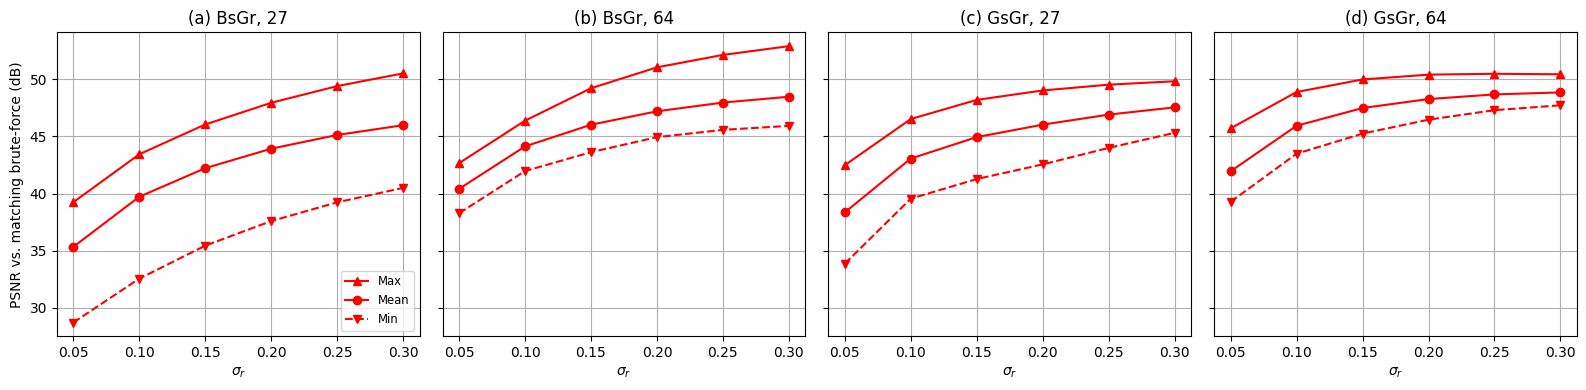

In [9]:
def compute_psnr(img_ref: np.ndarray, img_test: np.ndarray, max_val: float = 1.0):
    mse = np.mean((img_ref - img_test) ** 2)
    if mse == 0:
        return float('inf')
    return 10 * np.log10((max_val ** 2) / mse)

import math, os, glob, cv2, numpy as np, matplotlib.pyplot as plt
from numba import njit, prange

# ==============================================================
# 1)   BRUTE‑FORCE
# ==============================================================

@njit(parallel=True, fastmath=True)
def bilateral_bruteforce_box(img, radius=15, sigma_r=0.1, eps=1e-8):
    H, W, C = img.shape
    out = np.zeros_like(img, dtype=np.float32)
    for y in prange(H):
        for x in range(W):
            wp  = 0.0
            acc = np.zeros(C, np.float32)
            c0  = img[y, x]
            for dy in range(-radius, radius+1):
                yy = min(max(y+dy, 0), H-1)
                for dx in range(-radius, radius+1):
                    xx = min(max(x+dx, 0), W-1)
                    wr = math.exp(-np.sum((img[yy,xx]-c0)**2)/(2*sigma_r*sigma_r))
                    wp  += wr
                    acc += wr * img[yy, xx]
            out[y, x] = acc / (wp + eps)
    return out

@njit(parallel=True, fastmath=True)
def bilateral_bruteforce_gauss(img, radius=15, sigma_r=0.1, eps=1e-8):
    H, W, C = img.shape
    sigma_s2 = (radius/3.0)**2
    gsp = np.empty((2*radius+1, 2*radius+1), np.float32)
    for dy in range(-radius, radius+1):
        for dx in range(-radius, radius+1):
            gsp[dy+radius, dx+radius] = math.exp(-(dx*dx+dy*dy)/(2*sigma_s2))

    out = np.zeros_like(img, dtype=np.float32)
    for y in prange(H):
        for x in range(W):
            wp  = 0.0
            acc = np.zeros(C, np.float32)
            c0  = img[y, x]
            for dy in range(-radius, radius+1):
                yy = min(max(y+dy, 0), H-1)
                for dx in range(-radius, radius+1):
                    xx = min(max(x+dx, 0), W-1)
                    w = gsp[dy+radius, dx+radius] * \
                        math.exp(-np.sum((img[yy,xx]-c0)**2)/(2*sigma_r*sigma_r))
                    wp  += w
                    acc += w * img[yy, xx]
            out[y, x] = acc / (wp + eps)
    return out

# ==============================================================
# 2)   PIPELINE
# ==============================================================

def apply_proposed_filter(img_lin: np.ndarray,
                          method: str,
                          samples: np.ndarray,
                          sigma_r: float,
                          spatial_radius: int = 15) -> np.ndarray:
    if method == 'BsGr':
        Jks, Wks = box_filter(img_lin, samples,
                              sigma_r=sigma_r, spatial_radius=spatial_radius)
    elif method == 'GsGr':
        Jks, Wks = gaussian_iir_filter(img_lin, samples,
                                       sigma_r=sigma_r, spatial_radius=spatial_radius)
    else:
        raise ValueError(method)
    return interpolate(img_lin, samples, Jks, Wks)

# ==============================================================
# 3)   THỬ NGHIỆM
# ==============================================================

sigma_list = np.linspace(0.05, 0.30, 6)
configs = [('BsGr', 27), ('BsGr', 64), ('GsGr', 27), ('GsGr', 64)]
results = {cfg: [] for cfg in configs}

img_dir = r'D:\Image Processing\test'
paths = sorted(glob.glob(os.path.join(img_dir, '*.jpg')))
assert paths, 'No test images found!'

for path in paths:
    img_rgb = cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB).astype(np.float32)/255.0
    img_lin = inv_gamma(img_rgb)

    for method, n in configs:
        samples = poisson_disk_sampling(img_lin, num_samples=n, initial_rs=0.1)
        psnrs = []
        for sigma in sigma_list:
            # ----- ground‑truth khớp kernel -----
            if method == 'BsGr':
                ref_lin = bilateral_bruteforce_box(img_lin, 15, sigma)
            else:  # GsGr
                ref_lin = bilateral_bruteforce_gauss(img_lin, 15, sigma)

            ref_srgb = gamma_corr(ref_lin)
            out_lin  = apply_proposed_filter(img_lin, method, samples,
                                             sigma, spatial_radius=15)
            out_srgb = gamma_corr(out_lin)

            psnrs.append(compute_psnr(ref_srgb, out_srgb))
        results[(method, n)].append(psnrs)

# ==============================================================
# 4)   VẼ ĐỒ THỊ
# ==============================================================

agg = {cfg: {'max': np.max(lst,0), 'mean': np.mean(lst,0), 'min': np.min(lst,0)}
       for cfg,lst in results.items()}

fig, axes = plt.subplots(1,4,figsize=(16,4),sharey=True)
titles = ['(a) BsGr, 27', '(b) BsGr, 64', '(c) GsGr, 27', '(d) GsGr, 64']
for ax, cfg, ttl in zip(axes, configs, titles):
    d = agg[cfg]
    ax.plot(sigma_list, d['max'],  'r^-', label='Max')
    ax.plot(sigma_list, d['mean'], 'ro-', label='Mean')
    ax.plot(sigma_list, d['min'],  'rv--', label='Min')
    ax.set_title(ttl); ax.set_xlabel(r'$\sigma_r$'); ax.grid(True)
    ax.xaxis.set_major_locator(plt.MultipleLocator(0.05))

axes[0].set_ylabel('PSNR vs. matching brute-force (dB)')
axes[0].legend(loc='lower right', fontsize='small')
plt.tight_layout(); plt.show()

[Sampler] Poisson disk sampling: 0.388s → 27 samples


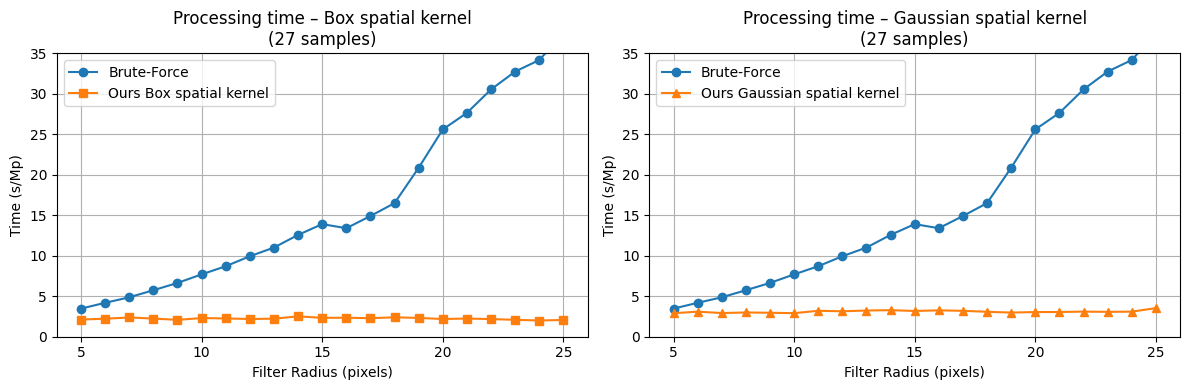

In [10]:
img_bgr = cv2.imread(r'D:\Image Processing\test\test6.jpg')
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB).astype(np.float32)/255.0
img_lin = inv_gamma(img_rgb)

sampler = poisson_disk_sampling(img_lin, num_samples=27, initial_rs=0.1)
samples = sampler

H, W = img_lin.shape[:2]
scale = (H * W) / 1e6

radii = list(range(5, 26, 1))
times_box = []
times_brute_force = []
times_gauss = []


for r in radii:
    t0 = time.time()
    Jks, Wks = box_filter(img_lin, samples, sigma_r=0.1, spatial_radius=r)
    t = time.time() - t0
    times_box.append(t / scale)

_ = gaussian_iir_filter(img_lin, samples, sigma_r=0.1, spatial_radius=5)
for r in radii:
    t0 = time.time()
    Jks, Wks = gaussian_iir_filter(img_lin, samples, sigma_r=0.1, spatial_radius=r)
    t = time.time() - t0
    times_gauss.append(t / scale)

_ = brute_force_filter(img_lin, samples, sigma_r=0.1, spatial_radius=5)
for r in radii:
    t0 = time.time()
    Jks, Wks = brute_force_filter(img_lin, samples, sigma_r=0.1, spatial_radius=r)
    t = time.time() - t0
    times_brute_force.append(t / scale)

# Vẽ biểu đồ
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# --- (a) Box spatial kernel comparison ---
axes[0].plot(radii, times_brute_force, marker='o', label='Brute-Force')
axes[0].plot(radii, times_box,         marker='s', label='Ours Box spatial kernel')
axes[0].set_title('Processing time – Box spatial kernel\n(27 samples)')
axes[0].set_xlabel('Filter Radius (pixels)')
axes[0].set_ylabel('Time (s/Mp)')
axes[0].grid(True)
axes[0].yaxis.set_major_locator(ticker.MultipleLocator(5))
axes[0].xaxis.set_major_locator(ticker.MultipleLocator(5))
axes[0].set_ylim(0, 35)
axes[0].legend()

# --- (b) Gaussian spatial kernel comparison ---
axes[1].plot(radii, times_brute_force, marker='o', label='Brute-Force')
axes[1].plot(radii, times_gauss,       marker='^', label='Ours Gaussian spatial kernel')
axes[1].set_title('Processing time – Gaussian spatial kernel\n(27 samples)')
axes[1].set_xlabel('Filter Radius (pixels)')
axes[1].set_ylabel('Time (s/Mp)')
axes[1].grid(True)
axes[1].yaxis.set_major_locator(ticker.MultipleLocator(5))
axes[1].xaxis.set_major_locator(ticker.MultipleLocator(5))
axes[1].set_ylim(0, 35)
axes[1].legend()

plt.tight_layout()
plt.show()